In [1]:
import pandas as pd
import seaborn as sns
import os,io
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.collections as clt
import matplotlib

from tifffile import imread
import numpy as np
from natsort import index_natsorted
import time
import h5py, hdf5plugin
import tqdm
from matplotlib.offsetbox import AnchoredText
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 7
        }
padding = {
    'titlepad': 3,
    'labelpad': 1,
}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **padding)

In [3]:
data = pd.read_csv('benchmark.csv')
data

Unnamed: 0   Dataset     Compression Method  Compressed Size  Read Time   
0             0  Brainbow           Uncompressed       33558968.0   0.038847  \
1             1  Brainbow           Uncompressed       33558968.0   0.020819   
2             2  Brainbow           Uncompressed       33558968.0   0.054192   
3             3  Brainbow           Uncompressed       33558968.0   0.042896   
4             4  Brainbow           Uncompressed       33558968.0   0.220873   
..          ...       ...                    ...              ...        ...   
620         620     STORM  SVTAV1_LESSSLOW_10bit         194543.0   0.194244   
621         621     STORM  SVTAV1_LESSSLOW_10bit         232204.0   0.220428   
622         622     STORM  SVTAV1_LESSSLOW_10bit         243095.0   0.206501   
623         623     STORM  SVTAV1_LESSSLOW_10bit         202606.0   0.198562   
624         624     STORM  SVTAV1_LESSSLOW_10bit         219858.0   0.211000   

     Write Time     NRMSE       PSNR      SSIM  Compression Ratio   
0      0.040677  0.000000        inf  1.000000           1.000000  \
1      0.028462  0.000000        inf  1.000000           1.000000   
2      0.027334  0.000000        inf  1.000000           1.000000   
3      0.025294  0.000000        inf  1.000000           1.000000   
4      0.027103  0.000000        inf  1.000000           1.000000   
..          ...       ...        ...       ...                ...   
620    5.082766  0.150111  57.550673  0.976429         172.501545   
621    5.719910  0.147590  57.659656  0.969723         144.523643   
622    5.045482  0.129328  56.919432  0.975796         138.048779   
623    5.023642  0.147544  57.678868  0.975461         165.636595   
624    5.457607  0.146842  57.741663  0.971772         152.639285   

     Effective Compression Rate (MB/s)  Effective Decompression Rate (MB/s)  
0                           825.004623                           863.881387  
1                          1179.082525                          1611.961907  
2                          1227.738307                           619.262523  
3                          1326.740129                           782.341378  
4                          1238.192751                           151.937930  
..                                 ...                                  ...  
620                           6.602501                           172.767370  
621                           5.867045                           152.244750  
622                           6.651290                           162.511994  
623                           6.680207                           169.009696  
624                           6.149026                           159.047268  

[625 rows x 12 columns]

In [4]:
data['Compression Method'] = [x.replace('SVTAV1', 'AV1') for x in data['Compression Method']]

/tmp/ipykernel_4163457/3196180346.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


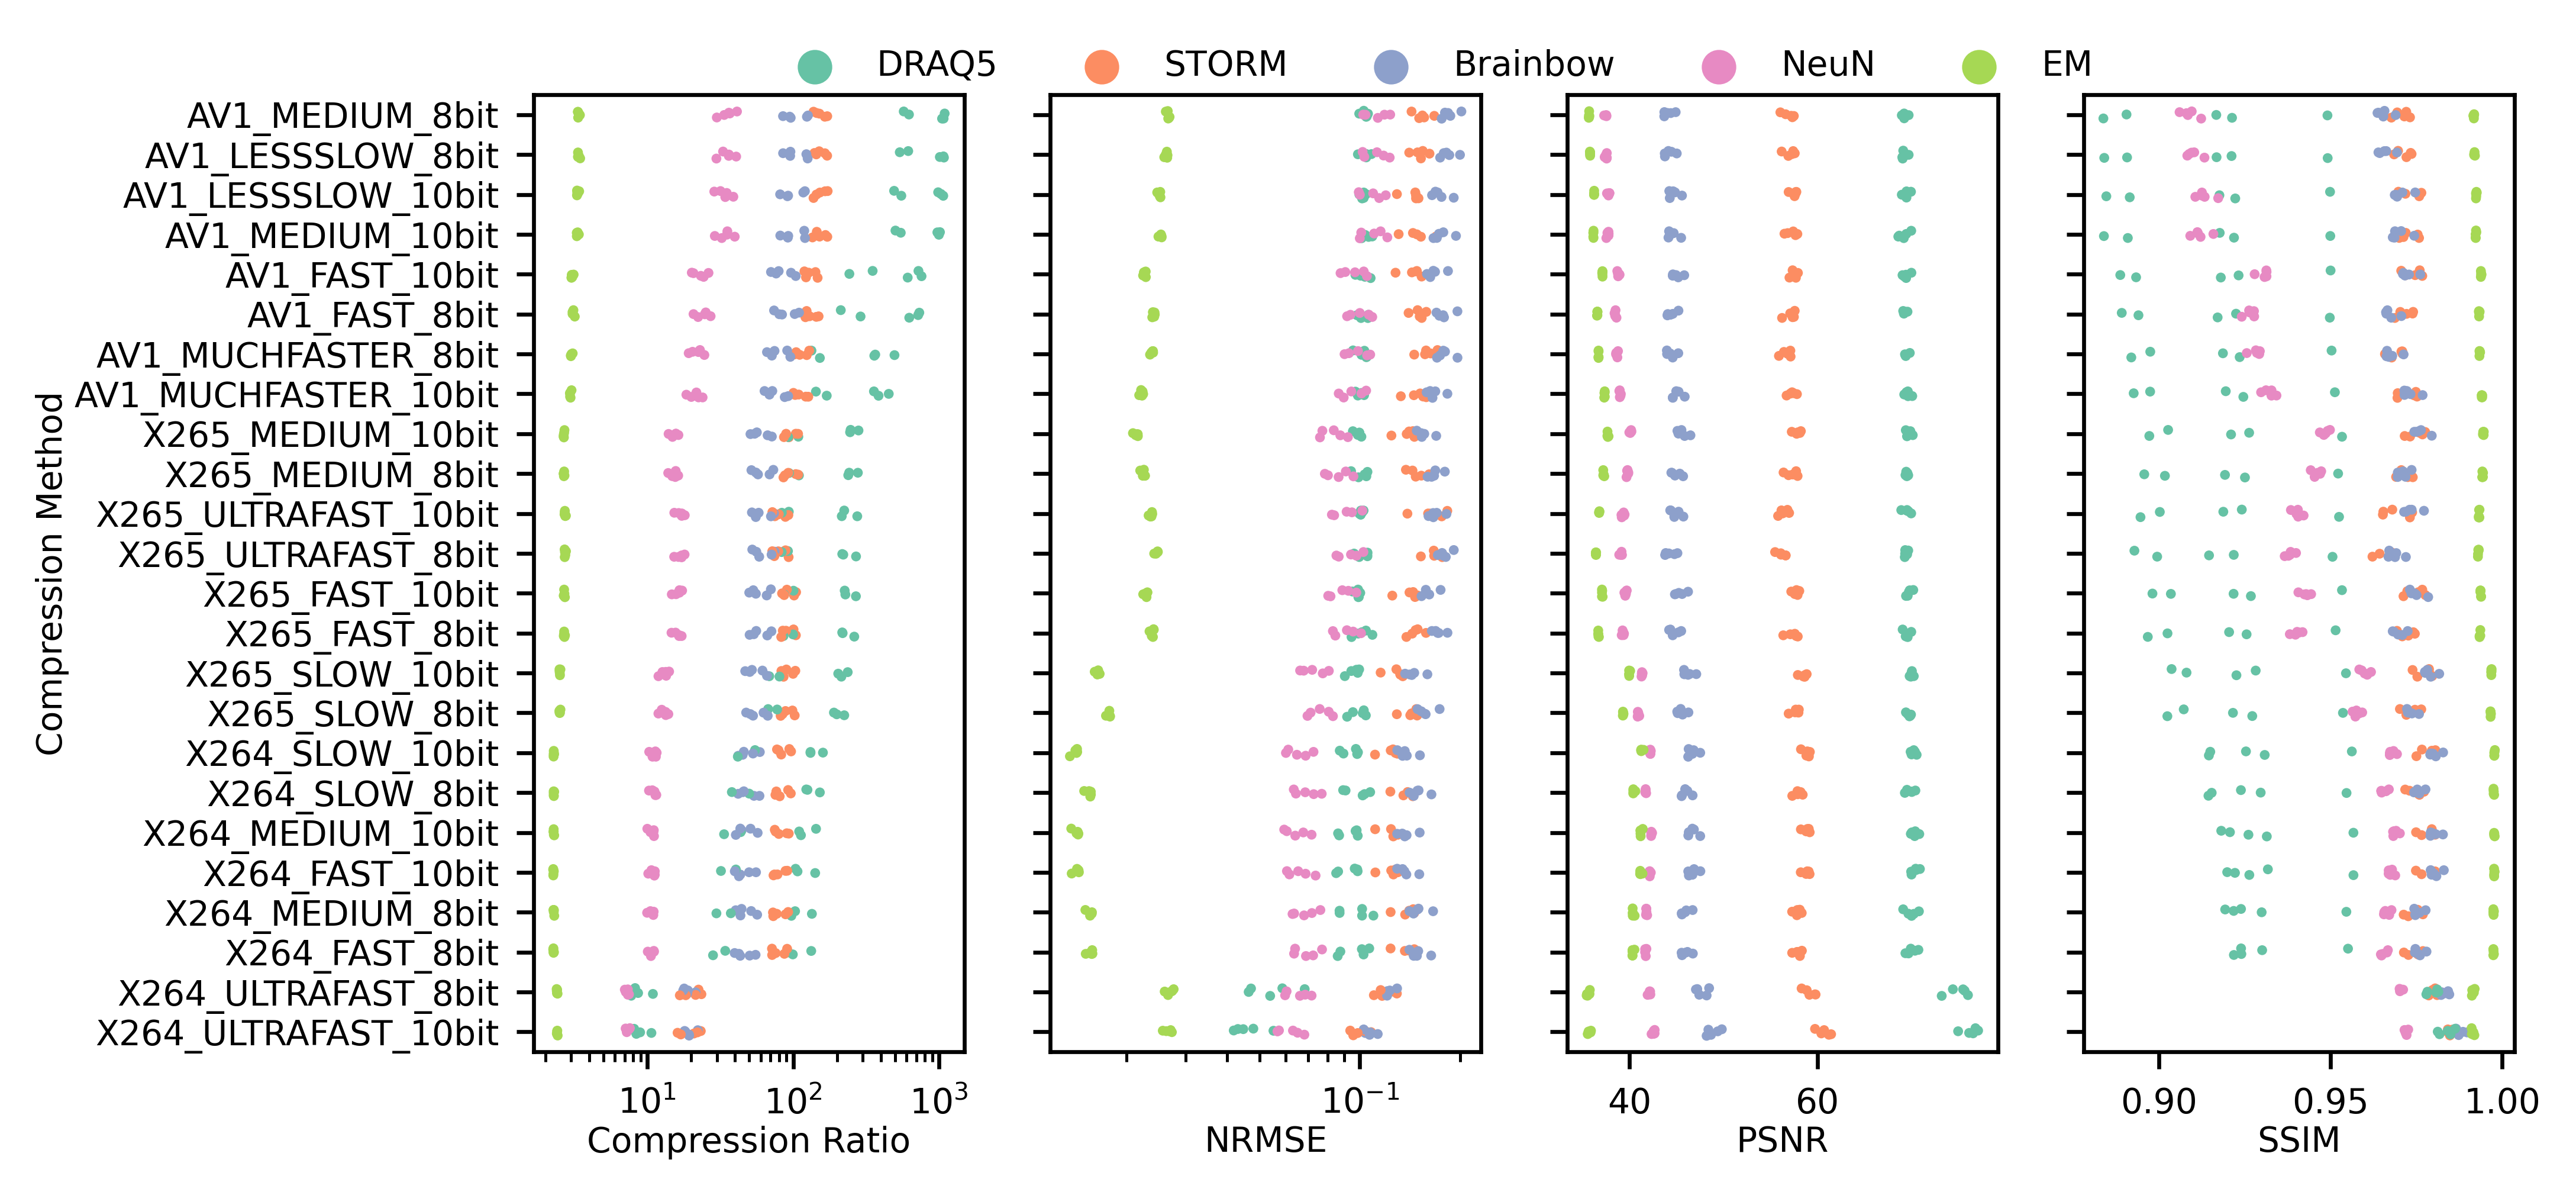

In [5]:
fig, ax  = plt.subplots(figsize=(7.2,3.5), dpi=600, ncols=4, sharey=True)

sns.set_palette('Set2')

# toplot = data.sort_values(by=['Compression Method'], ascending=False)
toplot = data[data['NRMSE'] > 0]
toplot = toplot.sort_values(by="Compression Ratio", ascending=False)

sns.stripplot(y='Compression Method', x="Compression Ratio", hue='Dataset', data=toplot, orient='h', size=2, marker='o', ax=ax[0])
sns.stripplot(y='Compression Method', x="NRMSE", hue='Dataset', data=toplot, orient='h', size=2, marker='o', ax=ax[1])
sns.stripplot(y='Compression Method', x="PSNR", hue='Dataset', data=toplot, orient='h', size=2, marker='o', ax=ax[2])
sns.stripplot(y='Compression Method', x="SSIM", hue='Dataset', data=toplot, orient='h', size=2, marker='o', ax=ax[3])

ax[0].set_xscale('log')
ax[1].set_xscale('log')

# ax.legend(loc="upper center", ncols=5, frameon=False, bbox_to_anchor=(0.5, 1.09))

for i in range(1, 4):
    ax[i].set_ylabel('')
    ax[i].legend([],[], frameon=False)

# strip_labels = ax[0].get_legend_handles_labels()
ax[0].legend(loc="upper left", ncols=5, frameon=False, bbox_to_anchor=(0.5, 1.08))
fig.tight_layout()
plt.subplots_adjust(right=0.9)
fig.savefig('benchmark.pdf', bbox_inches='tight')

In [6]:
sample_data = pd.read_csv('samples.csv')

In [7]:
datasets = ['Brainbow', 'NeuN', 'EM', 'DRAQ5', 'STORM']
codecs = ['Blosc-Zstd', 'X264', 'X265', 'SVTAV1']

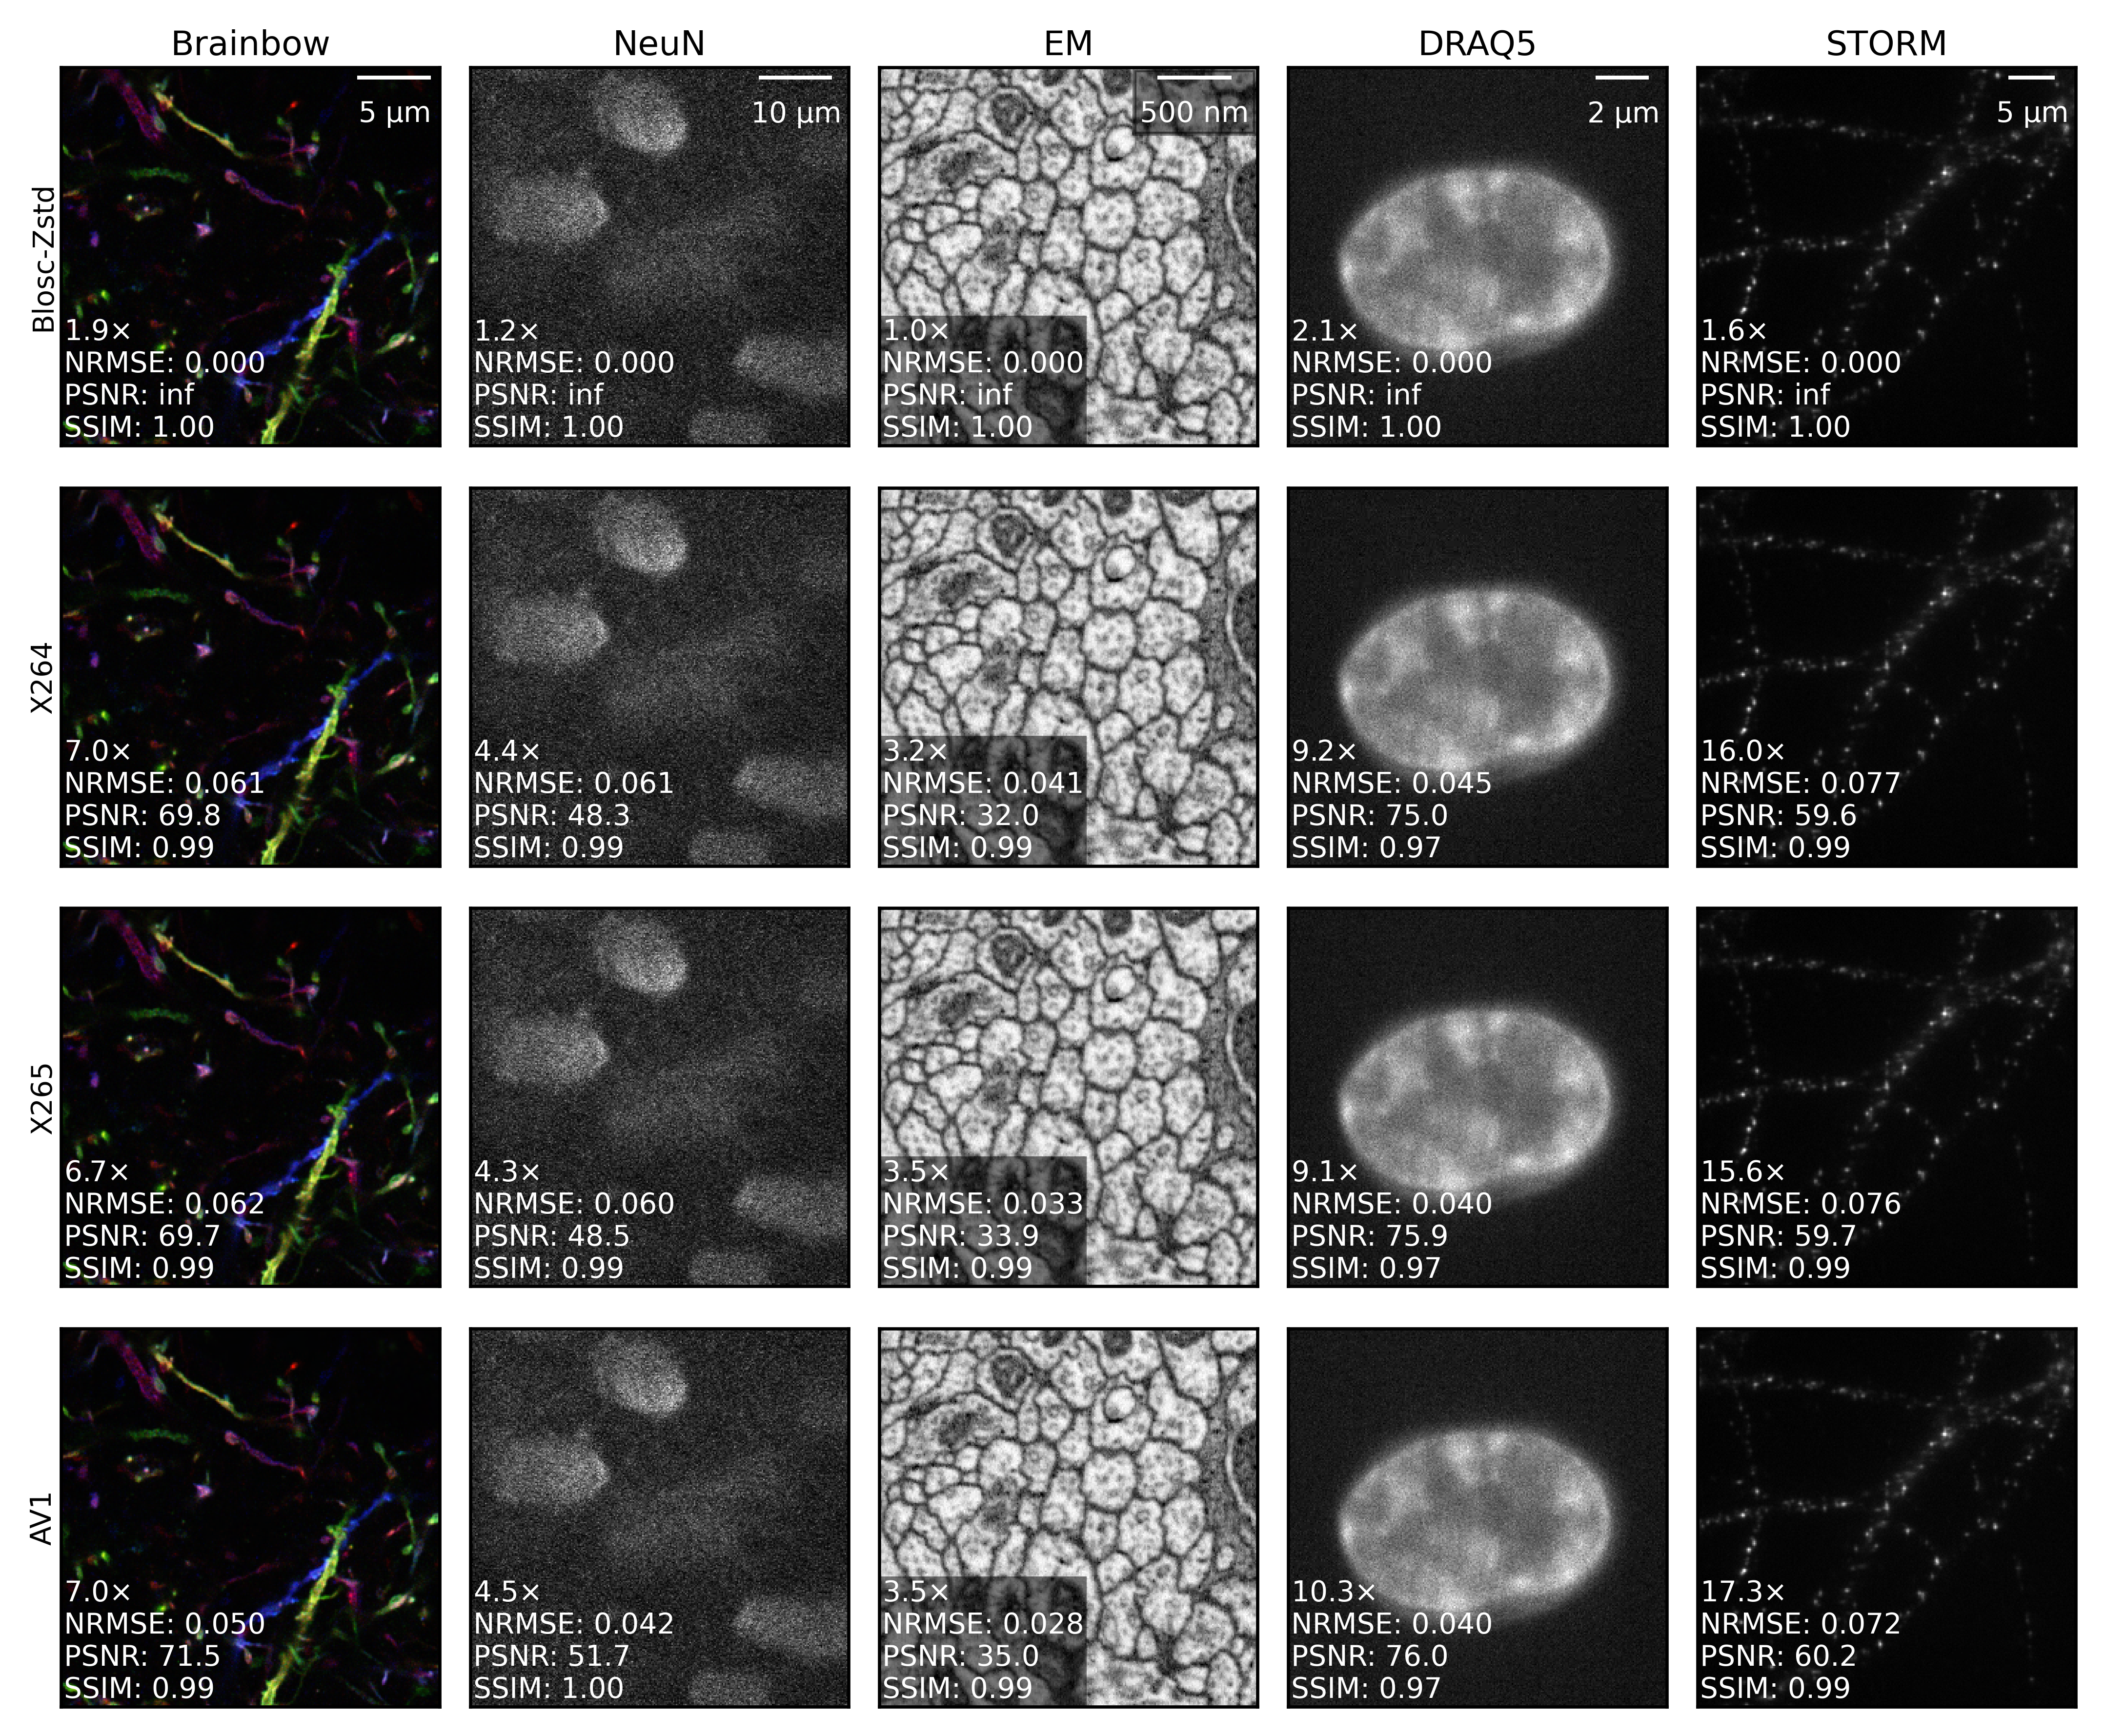

In [8]:
fig, axes = plt.subplots(figsize=(7.2,6), dpi=600, ncols=5, nrows=4)

for i, dname in zip(range(5), datasets):
    axes[0, i].set_title(dname)

#brainbow
axes[0, 0].add_artist(ScaleBar(0.1, 'um', location='upper right', frameon=False, color='w'))
#NeuN
axes[0, 1].add_artist(ScaleBar(0.202, 'um', location='upper right', frameon=False, color='w'))
#EM
axes[0, 2].add_artist(ScaleBar(10, 'nm', location='upper right', box_color='k', box_alpha=0.5, color='w', width_fraction=0.01))
#DRAQ5
axes[0, 3].add_artist(ScaleBar(100/1.8, 'nm', location='upper right', frameon=False, color='w'))
#STORM
axes[0, 4].add_artist(ScaleBar(160 , 'nm', location='upper right', frameon=False, color='w'))

for i, cname in zip(range(4), codecs):
    axes[i, 0].set_ylabel(cname)

axes[i, 0].set_ylabel('AV1')

for i, cname in zip(range(4), codecs):
    for j, dname in zip(range(5), datasets):
        dset = imread(f'compressed/{cname}_{dname}.tif')
        if dname == 'Brainbow':
            img = np.stack([dset[11*4, ...], dset[11*4+1, ...], dset[11*4+2, ...]], axis=0).astype(float)
            for jj in range(img.shape[0]):
                img[jj] /= img[jj].max()
            img = np.transpose(img, [1, 2, 0])
            handler = axes[i, j].imshow(img)
        elif dname == 'DRAQ5':
            img = dset[197, ...]
            handler = axes[i, j].imshow(img, cmap='gray')
        elif dname == 'EM':
            img = dset[100, ...]
            handler = axes[i, j].imshow(img, cmap='gray')
        elif dname == 'STORM':
            img = dset[0, ...]
            handler = axes[i, j].imshow(img, cmap='gray')
        elif dname == 'NeuN':
            img = dset[20, ...]
            handler = axes[i, j].imshow(img, cmap='gray')

        df = sample_data.loc[(sample_data['Compression Method'] == cname) & (sample_data['Dataset'] == dname)]
        ratio = df.iloc[0]['Compression Ratio']
        NRMSE = df.iloc[0]['NRMSE']
        PSNR = df.iloc[0]['PSNR']
        SSIM = df.iloc[0]['SSIM']

        if dname == 'EM':
            at = AnchoredText(f'{ratio:.1f}$\\times$\nNRMSE: {NRMSE:.3f}\nPSNR: {PSNR:.1f}\nSSIM: {SSIM:.2f}', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=True, loc='lower left')
            at.patch.set_facecolor('k')
            at.patch.set_linewidth(0)
            at.patch.set_alpha(0.5)
        else:
            at = AnchoredText(f'{ratio:.1f}$\\times$\nNRMSE: {NRMSE:.3f}\nPSNR: {PSNR:.1f}\nSSIM: {SSIM:.2f}', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='lower left')
            
        axes[i, j].add_artist(at)

    # cb = plt.colorbar(handler, ax=axes[:, j], shrink=0.4, location='right', pad=0)
    # cb.formatter.set_powerlimits((0, 0))

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
fig.tight_layout()
fig.savefig('gallery.pdf')

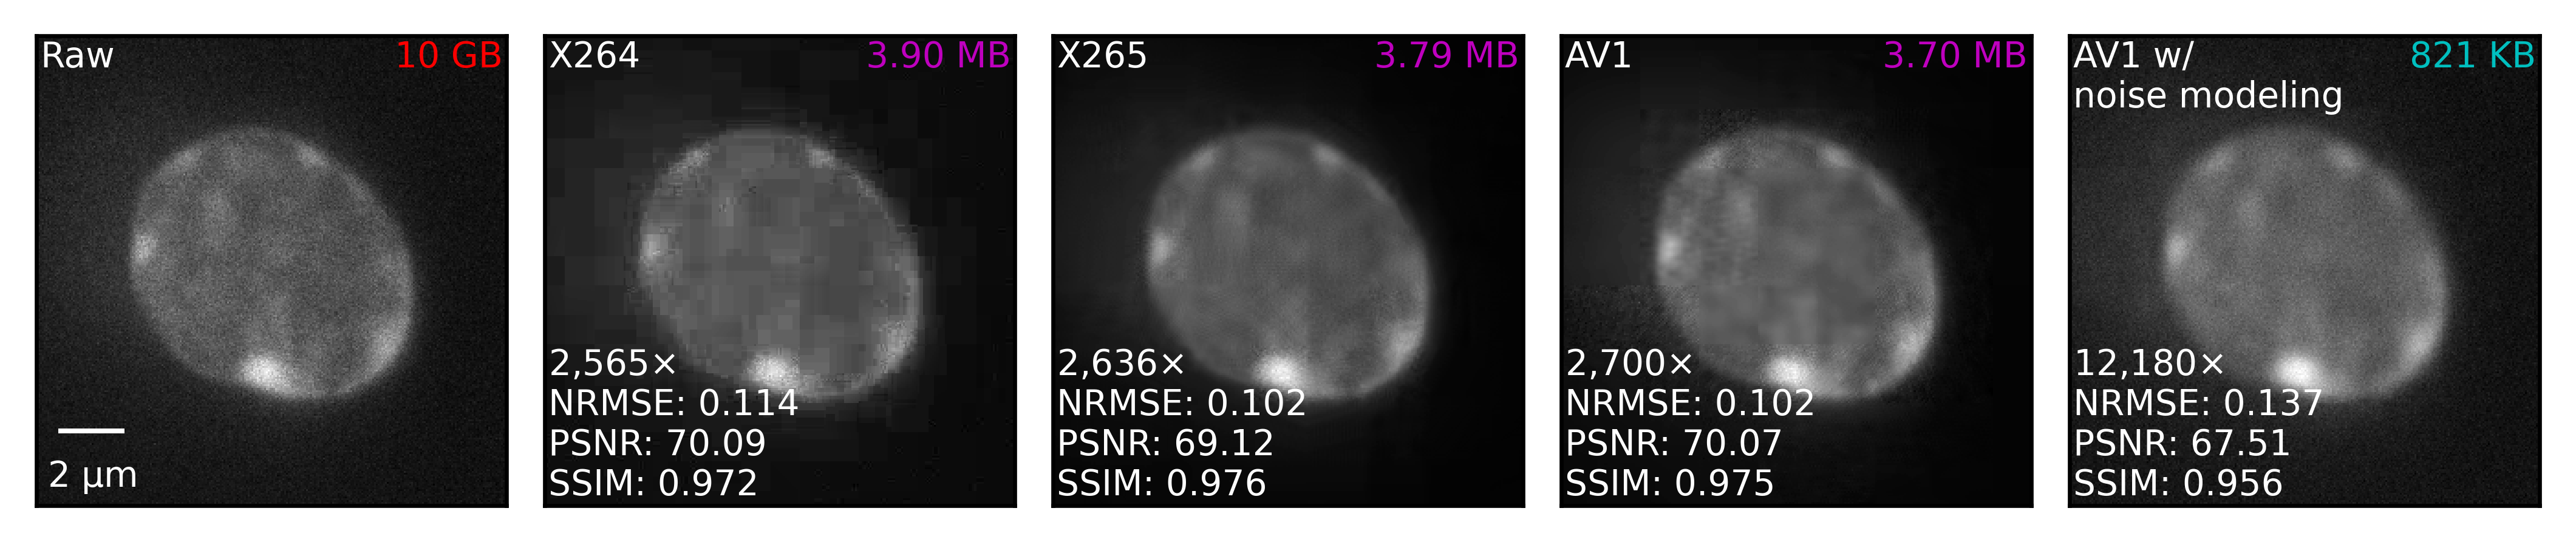

In [9]:
fig, axes = plt.subplots(figsize=(7.08,1.8), dpi=600, ncols=5, nrows=1)

from PIL import Image
axes = axes.flat

axes[0].imshow(np.array(Image.open('highly_compressed/raw.png')), cmap='gray')
# axes[0].set_title('Raw')
# axes[0].set_xlabel('10 GB', color='r')
axes[0].add_artist(ScaleBar(100/1.8, 'nm', location='lower left', frameon=False, color='w'))
axes[0].add_artist(AnchoredText('Raw', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='upper left'))
axes[0].add_artist(AnchoredText('10 GB', borderpad=0, pad=0.1, prop=dict(size=7, color='r'), frameon=False, loc='upper right'))

axes[1].imshow(np.array(Image.open('highly_compressed/x264_2565.png')), cmap='gray')
# axes[1].set_title('X264')
# axes[1].set_xlabel('3.90 MB', color='c')
axes[1].add_artist(AnchoredText('X264', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='upper left'))
axes[1].add_artist(AnchoredText('3.90 MB', borderpad=0, pad=0.1, prop=dict(size=7, color='m'), frameon=False, loc='upper right'))
at = AnchoredText(f'2,565$\\times$\nNRMSE: 0.114\nPSNR: 70.09\nSSIM: 0.972', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='lower left')
axes[1].add_artist(at)

axes[2].imshow(np.array(Image.open('highly_compressed/x265_2636.png')), cmap='gray')
# axes[2].set_title('X265')
# axes[2].set_xlabel('3.79 MB', color='c')
axes[2].add_artist(AnchoredText('X265', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='upper left'))
axes[2].add_artist(AnchoredText('3.79 MB', borderpad=0, pad=0.1, prop=dict(size=7, color='m'), frameon=False, loc='upper right'))
at = AnchoredText(f'2,636$\\times$\nNRMSE: 0.102\nPSNR: 69.12\nSSIM: 0.976', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='lower left')
axes[2].add_artist(at)

axes[3].imshow(np.array(Image.open('highly_compressed/AV1_2693_no_grain.png')), cmap='gray')
# axes[3].set_title('AV1')
# axes[3].set_xlabel('3.70 MB', color='c')
axes[3].add_artist(AnchoredText('AV1', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='upper left'))
axes[3].add_artist(AnchoredText('3.70 MB', borderpad=0, pad=0.1, prop=dict(size=7, color='m'), frameon=False, loc='upper right'))
at = AnchoredText(f'2,700$\\times$\nNRMSE: 0.102\nPSNR: 70.07\nSSIM: 0.975', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='lower left')
axes[3].add_artist(at)

axes[4].imshow(np.array(Image.open('highly_compressed/AV1_12222_grain15.png')), cmap='gray')
# axes[4].set_title('AV1 w/ noise modeling')
# axes[4].set_xlabel('821 KB', color='m')
axes[4].add_artist(AnchoredText('AV1 w/\nnoise modeling', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='upper left'))
axes[4].add_artist(AnchoredText('821 KB', borderpad=0, pad=0.1, prop=dict(size=7, color='c'), frameon=False, loc='upper right'))
at = AnchoredText(f'12,180$\\times$\nNRMSE: 0.137\nPSNR: 67.51\nSSIM: 0.956', borderpad=0, pad=0.1, prop=dict(size=7, color='w'), frameon=False, loc='lower left')
axes[4].add_artist(at)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
fig.tight_layout()
fig.savefig('high_compressed.pdf', bbox_inches='tight')

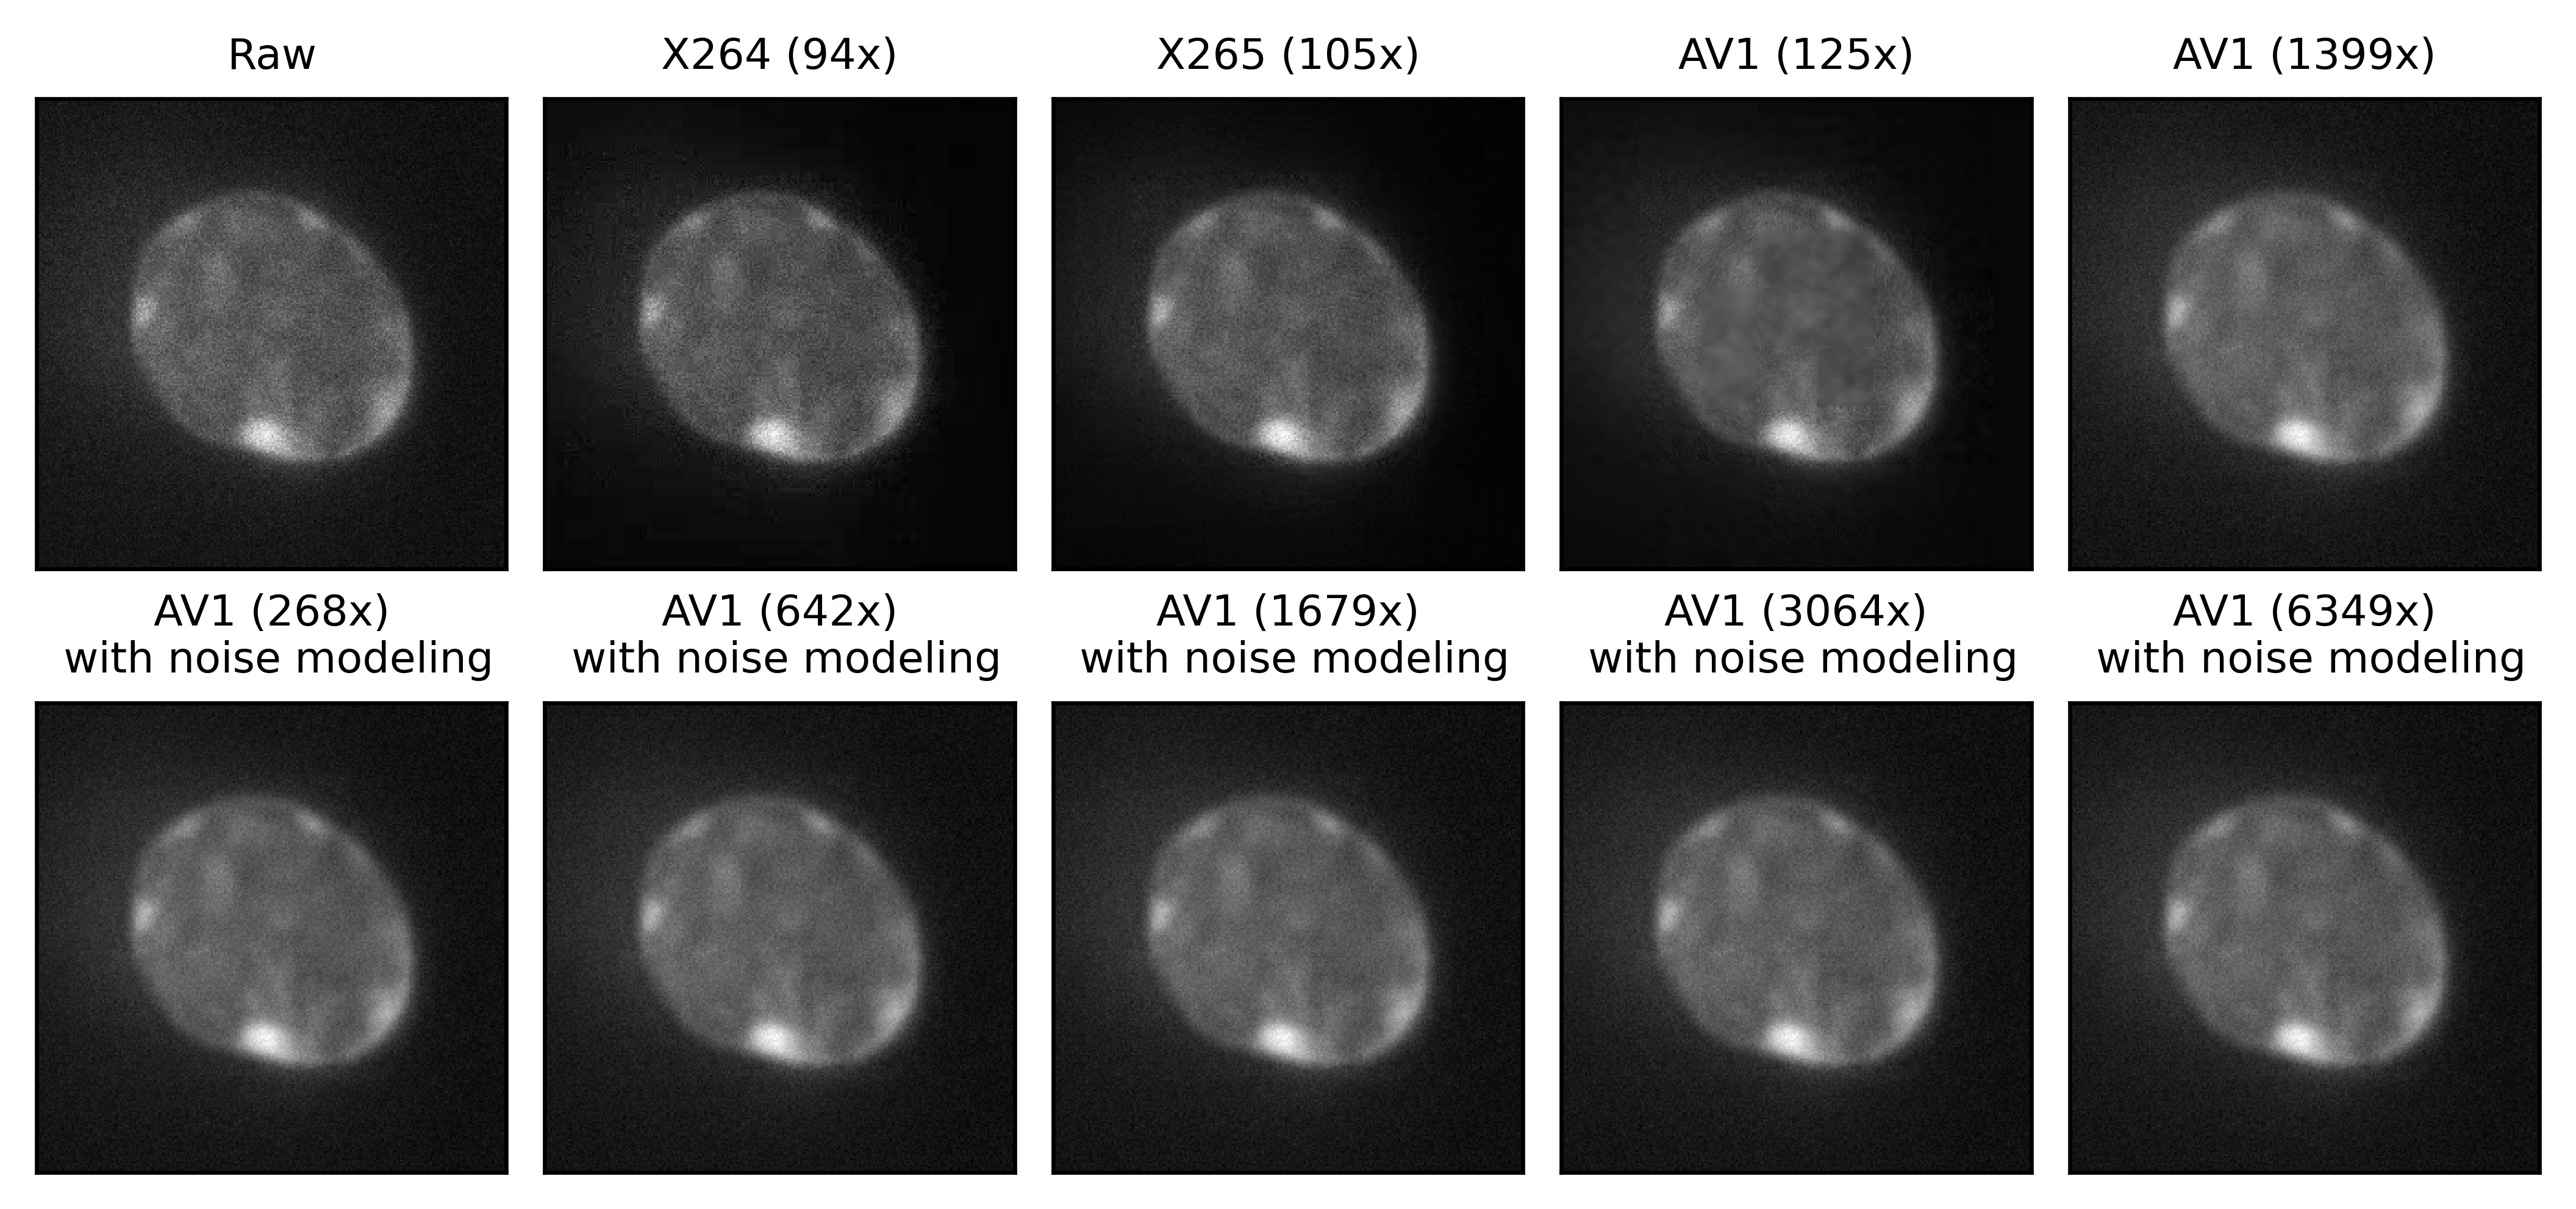

In [30]:
# fig, axes = plt.subplots(figsize=(7.05,3.4), dpi=600, ncols=5, nrows=2)

# from PIL import Image
# axes = axes.flat

# axes[0].imshow(np.array(Image.open('highly_compressed/raw.png')), cmap='gray')
# axes[0].set_title('Raw')

# axes[1].imshow(np.array(Image.open('highly_compressed/x264_94.png')), cmap='gray')
# axes[1].set_title('X264 (94x)')

# axes[2].imshow(np.array(Image.open('highly_compressed/x265_105.png')), cmap='gray')
# axes[2].set_title('X265 (105x)')

# axes[3].imshow(np.array(Image.open('highly_compressed/AV1_125_no_grain.png')), cmap='gray')
# axes[3].set_title('AV1 (125x)')

# axes[4].imshow(np.array(Image.open('highly_compressed/AV1_1679_grain15.png')), cmap='gray')
# axes[4].set_title('AV1 (1399x)')

# axes[5].imshow(np.array(Image.open('highly_compressed/AV1_1679_grain15.png')), cmap='gray')
# axes[5].set_title('AV1 (268x)\n with noise modeling')

# axes[6].imshow(np.array(Image.open('highly_compressed/AV1_1679_grain15.png')), cmap='gray')
# axes[6].set_title('AV1 (642x)\n with noise modeling')

# axes[7].imshow(np.array(Image.open('highly_compressed/AV1_1679_grain15.png')), cmap='gray')
# axes[7].set_title('AV1 (1679x)\n with noise modeling')

# axes[8].imshow(np.array(Image.open('highly_compressed/AV1_1679_grain15.png')), cmap='gray')
# axes[8].set_title('AV1 (3064x)\n with noise modeling')

# axes[9].imshow(np.array(Image.open('highly_compressed/AV1_1679_grain15.png')), cmap='gray')
# axes[9].set_title('AV1 (6349x)\n with noise modeling')

# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
    
# fig.tight_layout()
# fig.savefig('high_compressed.pdf')